Modified from https://github.com/atlas-outreach-data-tools/notebooks-collection-opendata/blob/master/13-TeV-examples/uproot_python/Find_the_Z.ipynb

The goal of this analysis is to determine the mass of the Z boson.

The Z boson has a lifetime of ~$10^{25}$ seconds and cannot be directly observed.
The Z boson decays into leptons and quarks.
We *can* detect leptons.
Specifically, when the Z boson decays into two leptons, we can:
    - Detect the two leptons
    - Calculate the invariant mass of the two leptons
    - Take the invariant mass of the two leptons as the mass of the Z boson

The accepted mass of the Z boson is $91.1876 \pm 0.0021 \text{ GeV/c}^2$.

In [40]:
import uproot
import awkward as ak
import vector

import numpy as np
import pandas as pd
import numpy as np
from scipy.special import voigt_profile
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, AutoMinorLocator

**Particle momentum** is written as **4-vector**: $(E, p_x, p_y, p_z)$

- $E$ = Particle energy
- $p_x$ = Particle momentum in $x$ direction
- $p_y$ = Particle momentum in $y$ direction
- $p_z$ = Particle momentum in $z$ direction

The **mass** of an object can be calculated from its **4-vector**:

$$M^2 = E^2 - p^2$$

(This form uses natural units, where $c = 1$.)

In our data, we have the following variables:

- `pt`: Particle transverse momentum, or momentum in the direction perpendicular to the particle beam's original direction. $p_T = \sqrt{p_x^2 + p_y^2}$.
- `eta`: Pseudorapidity, or the angle of the particle's momentum in the detector
- `phi`: Angle of the particle's momentum in the $xy$-plane
- `E`: Particle energy

The `vector` module is able to calculate invariant mass from these variables.

In [41]:
def calc_mll(lep_pt, lep_eta, lep_phi, lep_E):
    p4 = vector.zip({"pt": lep_pt, "eta": lep_eta, "phi": lep_phi, "E": lep_E})
    invariant_mass = (p4[:,0] + p4[:,1]).M
    return invariant_mass

In [42]:
# Load data from file
data_file = "~/data/mc_147771.Zmumu.root"
tree = uproot.open(data_file)["mini"]

numevents = tree.num_entries
variables = ['lep_pt', 'lep_eta', 'lep_phi', 'lep_E']
data_iterator = tree.iterate(variables, entry_stop=numevents, library='ak')

# Iterate over events, calculate all masses
masses = []
for data_chunk in data_iterator:
    # Select events with two or more leptons
    mask = ak.num(data_chunk.lep_pt) >= 2
    data_chunk = data_chunk[mask]
    
    # Calculate invariant masses for selected events
    mll = calc_mll(data_chunk.lep_pt, data_chunk.lep_eta, data_chunk.lep_phi, data_chunk.lep_E)
    masses.append(mll)
    
full_masses = ak.concatenate(masses)

Z mass = 90.580 ± 0.874 GeV
Z width = 1.224 ± 2.412 GeV


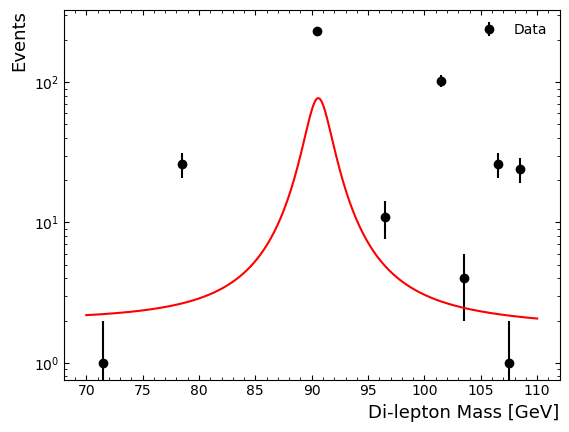

In [ ]:
# Calculate mass histogram
bin_edges = np.arange(start=70, stop=110, step=1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
data_x, _ = np.histogram(ak.to_numpy(full_masses), bins=bin_edges)
data_x_errors = np.sqrt(data_x)

# Fit curve to histogram
def voight_model(m, mZ, gamma, sigma, Nz, Nb, alpha):
    signal = Nz * voigt_profile(m - mZ, sigma, gamma)
    background = Nb * np.exp(-alpha * m)
    return signal + background

p0 = [91.2, 2.5, 1.5, max(data_x), min(data_x), 0.01]
params, cov = curve_fit(voight_model, bin_centers, data_x, p0=p0)
mZ, gammaZ, sigma, *_ = params
dmZ = np.sqrt(cov[0,0])
dgammaZ = np.sqrt(cov[1,1])

print(f"Z mass = {mZ:.3f} ± {dmZ:.3f} GeV")
print(f"Z width = {gammaZ:.3f} ± {dgammaZ:.3f} GeV")

# Plot histogram
main_axes = plt.gca()

main_axes.errorbar(
    x=bin_centers, y=data_x, yerr=data_x_errors,
    fmt='ko', label='Data'
)

main_axes.tick_params(
    which='both', direction='in',
    top=True, right=True
)

main_axes.set_xlabel(
    "Di-lepton Mass [GeV]",
    fontsize=13, x=1, horizontalalignment='right'
)
main_axes.set_ylabel(
    'Events',
    fontsize=13, y=1, horizontalalignment='right'
)
main_axes.set_yscale('log')

main_axes.xaxis.set_minor_locator(AutoMinorLocator())
main_axes.legend(frameon=False)

# Plot fit
m_fit = np.linspace(70, 110, 400)
y_fit = voight_model(m_fit, *params)
main_axes.plot(m_fit, y_fit, 'r-', label='Fit')